In [98]:
import pickle
import torch
import numpy as np
from scipy.cluster.vq import kmeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import math
from tqdm import tqdm
import pandas as pd

In [24]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Set the device to GPU
    device = torch.device('cuda')
    print('CUDA is available! Using GPU.')
else:
    # Set the device to CPU
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU.')

CUDA is available! Using GPU.


In [25]:
# Open the pickle file for reading in binary mode
with open('/kaggle/input/data-arxiv/Embeddings/Embeddings/daily_scibert_embeddings.pkl', 'rb') as f:
    # Load the object from the pickle file
    daily_scibert = pickle.load(f)
    
# Open the pickle file for reading in binary mode
with open('/kaggle/input/data-arxiv/Embeddings/Embeddings/daily_spectre_embeddings.pkl', 'rb') as f:
    # Load the object from the pickle file
    daily_spectre = pickle.load(f)
    
# Open the pickle file for reading in binary mode
with open('/kaggle/input/data-arxiv/Embeddings/Embeddings/poi_scibert_embeddings.pkl', 'rb') as f:
    # Load the object from the pickle file
    scibert_positive = pickle.load(f)

# Open the pickle file for reading in binary mode
with open('/kaggle/input/data-arxiv/Embeddings/Embeddings/poi_spectre_embeddings.pkl', 'rb') as f:
    # Load the object from the pickle file
    spectre_positive = pickle.load(f)

In [61]:
def get_centroids(k=5,method="scibert"):
    data=[]
    for i in range(len(scibert_positive)):
        if method=="scibert":
            v1=scibert_positive[i]['embedding']
        else:
            v1=spectre_positive[i]['embedding']
        data.append(v1[0].cpu())
    centroids, distortion = kmeans(data, k)
    return centroids,data

In [62]:
centres,data=get_centroids()

In [63]:
centres

array([[-0.52359587, -0.47714326, -0.9973244 , ..., -0.59820366,
         0.9031179 , -0.07096459],
       [-0.61152303, -0.6064908 , -0.9992545 , ..., -0.65816486,
         0.8940703 ,  0.05503137],
       [-0.49338394, -0.32317084, -0.9883106 , ..., -0.59757465,
         0.94702005, -0.12142906],
       [-0.3594623 , -0.26879022, -0.9865846 , ..., -0.47828007,
         0.9753859 , -0.19181266],
       [-0.31874457, -0.15346336, -0.9365562 , ..., -0.478988  ,
         0.96473   , -0.20750755]], dtype=float32)

In [65]:
unl_data=[]
for entry in daily_scibert:
    unl_data.append(entry["embedding"][0].cpu())

292


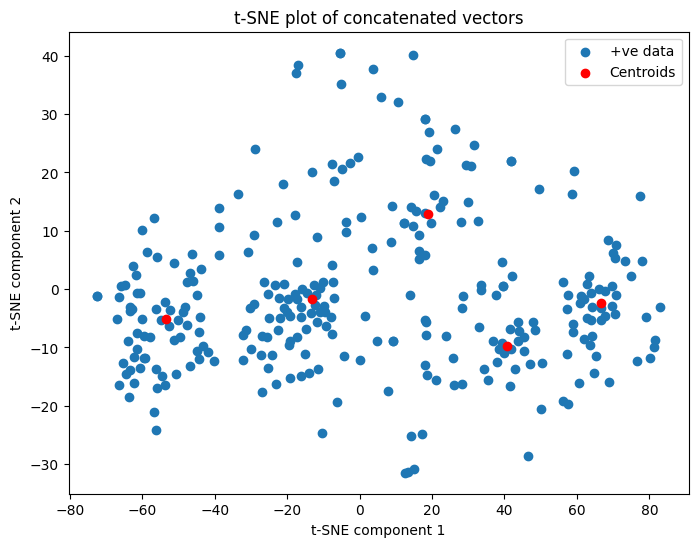

In [67]:
new_data=data.copy()
new_data.extend(centres)
new_data.extend(unl_data)
print(len(data))
tsne = TSNE(n_components=2, random_state=42)
embedded_vectors = tsne.fit_transform(np.array(new_data))

# Plot the embedded vectors
plt.figure(figsize=(8, 6))
plt.scatter(embedded_vectors[:len(data), 0], embedded_vectors[:len(data), 1], label='+ve data')
plt.scatter(embedded_vectors[len(data):len(data)+len(centres), 0], embedded_vectors[len(data):len(data)+len(centres), 1], c='r', label='Centroids')
plt.scatter(embedded_vectors[len(data)+len(centres):, 0], embedded_vectors[len(data)+len(centres):, 1], c='g', label='Unlabelled Data')
plt.title('t-SNE plot of concatenated vectors')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend()
plt.show()

In [80]:
def euclidean_distance(point1, point2):
    distance = 0
    for i in range(len(point1)):
        distance += (point1[i] - point2[i]) ** 2
    return math.sqrt(distance)

def get_distance(centres, method="scibert"):
    if method == "scibert":
        data = daily_scibert
    else:
        data = daily_spectre

    distances = {}
    pbar = tqdm(total=len(data), desc="Finding closest centers")
    count = 0
    for point in data:
        count+=1
        id_of = point["id"]
        point = point["embedding"][0]
        min_distance = float('inf')
        closest_center = None
        for center in centres:
            distance = euclidean_distance(point, center)
            if distance < min_distance:
                min_distance = distance
                closest_center = center
        distances[id_of,count] = min_distance
        pbar.update(1)
    pbar.close()
    return distances   

In [81]:
dist=get_distance(centres,method="scibert")
print(len(dist))

Finding closest centers: 100%|██████████| 1118/1118 [02:43<00:00,  6.84it/s]

1118


1118


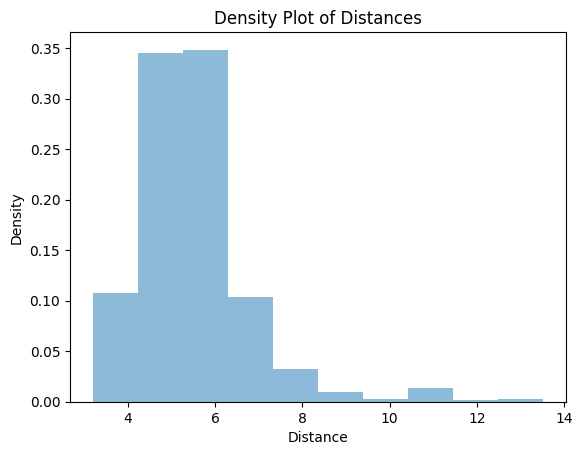

In [88]:
density_plot=[]
for key in dist.keys():
    density_plot.append(dist[key])
print(len(density_plot))
fig, ax = plt.subplots()
ax.hist(density_plot, density=True, histtype='stepfilled', alpha=0.5)
ax.set_title('Density Plot of Distances')
ax.set_xlabel('Distance')
ax.set_ylabel('Density')

# Show the plot
plt.show()

In [96]:
# We take threshold as 4.2
def filter_data(threshold,dist_dict):
    filtered_dict={}
    for key in dist_dict.keys():
        if dist_dict[key]<=threshold:
            filtered_dict[key]=dist_dict[key]
    print(len(filtered_dict))
    return filtered_dict

In [99]:
filtered_dict=filter_data(4.2,dist)

116


In [109]:
filtered_dict

{('oai:arXiv.org:2403.19783v1', 48): 4.035788649924011,
 ('oai:arXiv.org:2304.14178v3', 138): 4.16279579921557,
 ('http://arxiv.org/abs/2404.08608v1', 167): 3.8812447957911593,
 ('http://arxiv.org/abs/2404.08555v1', 174): 3.945276120461914,
 ('http://arxiv.org/abs/2404.08517v1', 178): 4.198042849528753,
 ('http://arxiv.org/abs/2404.08417v1', 194): 3.2516303741395416,
 ('http://arxiv.org/abs/2404.08408v1', 195): 3.5644444295698734,
 ('http://arxiv.org/abs/2404.08230v1', 215): 3.887726220911422,
 ('http://arxiv.org/abs/2404.08189v1', 217): 3.983106822725531,
 ('http://arxiv.org/abs/2404.09707v1', 233): 4.117312348009237,
 ('http://arxiv.org/abs/2404.09632v1', 244): 3.408595406328385,
 ('http://arxiv.org/abs/2404.09565v1', 254): 3.6750434353915002,
 ('http://arxiv.org/abs/2404.09536v1', 258): 4.049416940421552,
 ('http://arxiv.org/abs/2404.09533v1', 259): 4.1468624709859245,
 ('http://arxiv.org/abs/2404.09529v1', 261): 3.615114610894424,
 ('http://arxiv.org/abs/2404.09491v1', 269): 3.8877

In [101]:
daily_csv=pd.read_csv("/kaggle/input/data-arxiv/Data_Arxiv/Data_Arxiv/daily_arxiv_papers.csv")

In [114]:
keep_indexes=[]
for key in filtered_dict.keys():
    id,index=key
    keep_indexes.append(index-1)

new_df=daily_csv.iloc[keep_indexes]

In [117]:
len(new_df)

116

In [118]:
new_df.to_csv("FILTERED_EUCLIDEAN_DISTANCE.csv")

In [121]:
new_df

,id,title,abstract,date
47,oai:arXiv.org:2403.19783v1,AlloyBERT: Alloy Property Prediction with Larg...,arXiv:2403.19783v1 Announce Type: cross Abstr...,01-Apr-2024
137,oai:arXiv.org:2304.14178v3,mPLUG-Owl: Modularization Empowers Large Langu...,arXiv:2304.14178v3 Announce Type: replace-cros...,01-Apr-2024
166,http://arxiv.org/abs/2404.08608v1,Hyperbolic Delaunay Geometric Alignment,Hyperbolic machine learning is an emerging fie...,2024-04-12
173,http://arxiv.org/abs/2404.08555v1,RLHF Deciphered: A Critical Analysis of Reinfo...,State-of-the-art large language models (LLMs) ...,2024-04-12
177,http://arxiv.org/abs/2404.08517v1,"Online Safety Analysis for LLMs: a Benchmark, ...",While Large Language Models (LLMs) have seen w...,2024-04-12
...,...,...,...,...
1067,http://arxiv.org/abs/2404.16767v1,REBEL: Reinforcement Learning via Regressing R...,While originally developed for continuous cont...,2024-04-25
1075,http://arxiv.org/abs/2404.16663v1,"Formal Specification, Assessment, and Enforcem...",The risk of reinforcing or exacerbating societ...,2024-04-25
1081,http://arxiv.org/abs/2404.16621v1,Hippocrates: An Open-Source Framework for Adva...,The integration of Large Language Models (LLMs...,2024-04-25
1097,http://arxiv.org/abs/2404.16417v1,Constructing Optimal Noise Channels for Enhanc...,With the rapid advancement of Quantum Machine ...,2024-04-25
